json_file = dense.to_json()
with open('tl-model.json', "w") as file:
    file.write(json_file)
#serialize weights to HDF5
dense.save_weights('tf_model_weight.h5')

In [1]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

from sklearn.utils import resample
from keras.models import Sequential
from keras.layers import Dense, SeparableConv2D, Conv2D, MaxPooling2D,GlobalAveragePooling2D,MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping # prevent overfitting
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import auc, roc_curve
from keras.regularizers import l2
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet121
from keras.models import Model
import tensorflow as tf
#from imblearn.over_sampling import SMOTE



%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# main path
path = 'data/chest_xray/'

# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

# 0 is normal and 1 is pneumonia 
for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'class'])
test_df = pd.DataFrame(test_list, columns=['image', 'class'])
val_df = pd.DataFrame(val_list, columns=['image', 'class'])

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['class'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['class'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['class'])
plt.title('Validation data')

plt.show()

In [4]:
comb_df = pd.concat([train_df,val_df])
train_df_, val_df_ = train_test_split(comb_df, test_size = 0.1)
def balance(df):
    major = df[df['class'] == 1]
    minor = df[df['class'] == 0]
    minor_oversampled  = resample(minor,
                                 replace = True,
                                 n_samples = round(major['class'].value_counts()[1]),
                                 random_state = 42)
    combined_df = pd.concat([major, minor_oversampled])
    return combined_df
train_df = balance(train_df_)
val_df = balance(val_df_)
train_df = train_df.sample(frac = 1, random_state = 42)
val_df = val_df.sample(frac = 1,random_state = 42)

In [5]:
# pre-process & normalize image
def process_data_(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (320, 320))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img = img/255.0
    img = np.reshape(img, (320, 320,-1))
    img = tf.convert_to_tensor(img[:,:,:3])

    
    return img

# write a function to split img and label into 2 separate numpy arrays
def compose_dataset_(df):
    img = []
    labels = []

    for img_path, label in df.values:
        img.append(process_data_(img_path))
        labels.append(label)
        
    return np.array(img), np.array(labels)

In [6]:
X_train, y_train = compose_dataset_(train_df)
X_test, y_test = compose_dataset_(test_df)
X_val, y_val = compose_dataset_(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (6992, 320, 320, 3), Labels shape: (6992,)
Test data shape: (624, 320, 320, 3), Labels shape: (624,)
Validation data shape: (774, 320, 320, 3), Labels shape: (774,)


In [7]:
# define generator for traing data 
image_gen = ImageDataGenerator(
            #samplewise_center = True, #set each sample mean to 0 
            #samplewise_std_normalization = True, # divide each input by its std to normalize 
            #rescale = 1./255,
            rotation_range = 30, # randomly rotate image from -30 degree to 30 degree
            width_shift_range = 0.1, #randomly shift images horizontally
            height_shift_range = 0.1, #randomly shift images vertically
            shear_range = 0.1, #randomly change shear intensity
            zoom_range = 0.2, # random zoom images
            horizontal_flip = False, # randomly flip images
            vertical_flip = False
)

# fit generator on our train features
image_gen.fit(X_train)

In [8]:
dense = Sequential()
dense.add(DenseNet121(include_top = False, weights = 'imagenet', input_shape = (320, 320,3)))
#input_tensor = Input(shape=(224,224,1)
#dense.Conv2D(3,(3,3),padding='same')(input_tensor)
for layer in dense.layers:
        layer.trainable = False
dense.add(GlobalAveragePooling2D())
dense.add(Dense(128, activation = 'relu'))
dense.add(Dense(256, activation='relu'))
dense.add(BatchNormalization())
dense.add(Dropout(0.4))
    
dense.add(Dense(64, activation='relu'))
    
dense.add(BatchNormalization())
    
dense.add(Dropout(0.4))
    
dense.add(Dense(32, activation='relu'))
    
dense.add(BatchNormalization())
    
dense.add(Dropout(0.3))
dense.add(Dense(1, activation='sigmoid'))


#dense.add(Flatten())
#dense.add(Dense(1, activation = 'sigmoid'))
#dense.layers[0].trainable=False
dense.compile(Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])
dense.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1

In [9]:
batch_size = 64
steps_per_epoch = train_df.shape[0] // batch_size
validation_steps = val_df.shape[0] // batch_size
validation_steps

12

In [10]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.3, patience=5, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 3, mode='min')


In [11]:
hist_2 = dense.fit_generator(image_gen.flow(X_train, y_train, batch_size = batch_size), #train set 
                 validation_data = (X_val, y_val), 
                 epochs = 15,
                 steps_per_epoch = steps_per_epoch,
                 verbose =1,
                 #class_weight= modified_weight_)
                 #validation_steps = 25
                 callbacks = [lr])

Epoch 1/15
109/109 [==============================] - 183s 2s/step - loss: 0.7576 - accuracy: 0.6188 - val_loss: 0.5789 - val_accuracy: 0.6783
Epoch 2/15
109/109 [==============================] - 160s 1s/step - loss: 0.4415 - accuracy: 0.8090 - val_loss: 0.4444 - val_accuracy: 0.7752
Epoch 3/15
109/109 [==============================] - 160s 1s/step - loss: 0.3351 - accuracy: 0.8678 - val_loss: 0.2487 - val_accuracy: 0.9096
Epoch 4/15
109/109 [==============================] - 160s 1s/step - loss: 0.3070 - accuracy: 0.8712 - val_loss: 0.2232 - val_accuracy: 0.9147
Epoch 5/15
109/109 [==============================] - 160s 1s/step - loss: 0.2728 - accuracy: 0.8917 - val_loss: 0.1783 - val_accuracy: 0.9315
Epoch 6/15
109/109 [==============================] - 160s 1s/step - loss: 0.2440 - accuracy: 0.9078 - val_loss: 0.1547 - val_accuracy: 0.9354

Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
Epoch 7/15
109/109 [==============================] - 160s 1

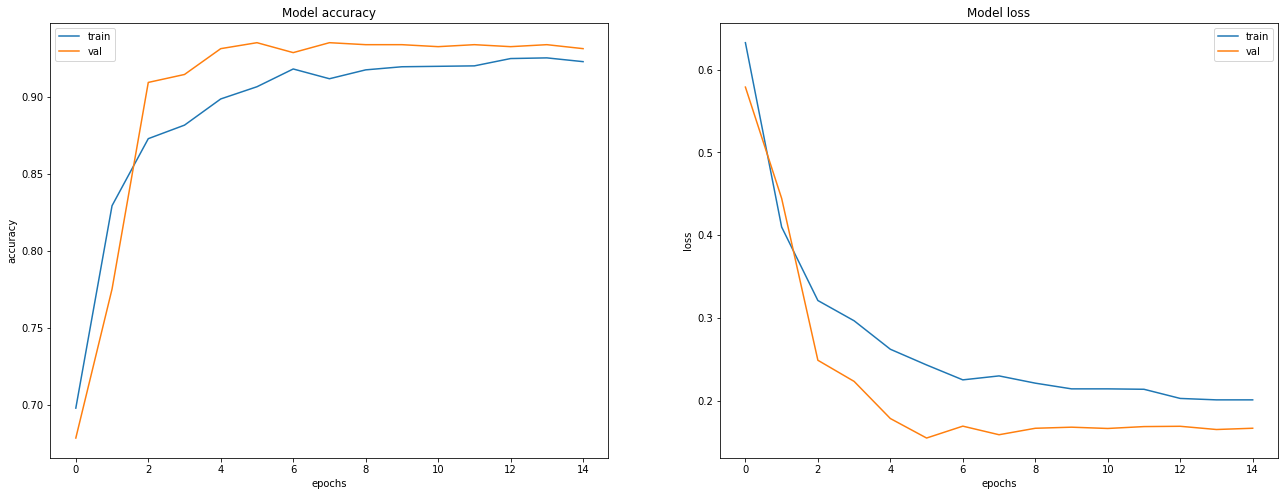

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist_2.history[met])
    ax[i].plot(hist_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig('good-acc-loss.jpeg')

In [13]:
y_pred_ = dense.predict_classes(X_test, batch_size=32)

cm = confusion_matrix(y_test, y_pred_)

In [14]:
cm

array([[209,  25],
       [ 30, 360]])

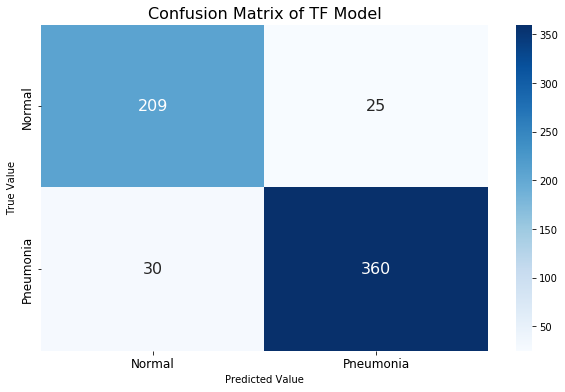

In [15]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 16})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
ax.set_xticklabels(['Normal','Pneumonia'], fontsize = 12)
ax.set_yticklabels(['Normal','Pneumonia'], va='center', rotation = 90, position=(0,0.28),fontsize = 12)
plt.title('Confusion Matrix of TF Model' , fontsize = 16)
plt.savefig('graph/confusion-matrix-tf-avg.png')

In [16]:
classification_rep = classification_report(y_test, y_pred_)
#classification_report
print(classification_rep)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       234
           1       0.94      0.92      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.91      0.91       624
weighted avg       0.91      0.91      0.91       624



In [17]:
y_pred_keras = dense.predict_proba(X_test)
fpr, tpr, thres = roc_curve(y_test, y_pred_keras)

In [18]:
# Roc curve
# Calculate gmeans
gmeans = np.sqrt(tpr * (1-fpr))
# Get the best threshold
ix = np.argmax(gmeans)
best_thres = thres[ix]
print('Best Threshold = {}'.format(best_thres))

Best Threshold = 0.48880884051322937


In [19]:
auc_keras = auc(fpr, tpr)

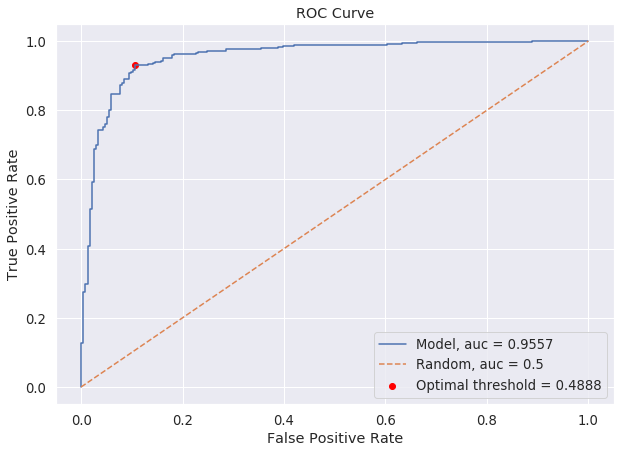

In [20]:
plt.subplots(figsize = (10,7))
plt.plot(fpr,tpr,label = dense)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'red', label = 'Best threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(labels = ['Model, auc = {:.4f}'.format(auc_keras), 'Random, auc = 0.5', 'Optimal threshold = {:.4f}'.format(best_thres)])
plt.savefig('graph/av-roc-dense.png')

ValueError: Colormap RGB is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

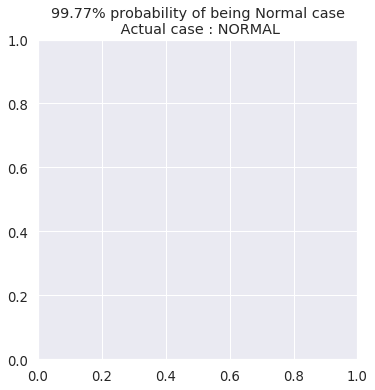

In [23]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+55, 9+55):
  plt.subplot(3, 3, (i-55)+1)
  if y_pred_[i] >=  0.716621398: 
      out = ('{:.2%} probability of being Pneumonia case'.format(y_pred_keras[i][0]))
         
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-y_pred_keras[i][0]))
      
      

  plt.title(out + "\n Actual case : "+ dic.get(y_test[i]))    
  plt.imshow(np.squeeze(X_test[i]))
  plt.axis('off')
plt.savefig('graph/dense-model.jpeg')

In [22]:
cut here = 

SyntaxError: invalid syntax (<ipython-input-22-9d69fd592ec4>, line 1)

# Data Augmentation

In [ ]:
for i,img_path in enumerate(train_df[train_df['class'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')

In [ ]:
image, label = next(iter(train_df))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+55, 9+55):
  plt.subplot(3, 3, (i-55)+1)
  if y_pred[i] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(y_pred_keras[i][0]))
         
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-y_pred_keras[i][0]))
      
      
​
  plt.title(out + "\n Actual case : "+ dic.get(y_test[i]))    
  plt.imshow(np.squeeze(X_test[i]))
  plt.axis('off')
plt.savefig('graph/example-acc-0.7881.jpeg')


In [ ]:
from tensorflow.keras.preprocessing import image
sample_path = 'sample-xray.jpg'

In [ ]:
fig = plt.subplots(figsize = (12,12))
# preprocess sample imgage
covid_img = image.load_img(sample_path, target_size = (320,320), color_mode = 'grayscale')
covid_img = image.img_to_array(covid_img)
covid_img = cv2.cvtColor(covid_img, cv2.COLOR_BGR2RGB)
covid_img = covid_img/255
covid_img = np.expand_dims(covid_img, axis=0)

plt.imshow(np.squeeze(covid_img))

In [ ]:
#img = tf.expand_dims(covid_img, 0)

In [ ]:
image_gen.fit(covid_img)

In [ ]:
plt.figure(figsize=(12, 12))
i=0
for img_batch in image_gen.flow(covid_img, batch_size=9):
    for img in img_batch:
        ax = plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.grid(b=None)

        #plt.axis("off")
        i=i+1    
    if i >= batch_size:
        break

plt.savefig('augmentation-example.jpeg')

In [ ]:
y_pred_keras = dense.predict_proba(X_test)
fpr, tpr, thres = roc_curve(y_test, y_pred_keras)

In [ ]:
auc_keras = auc(fpr, tpr)

In [ ]:
# Calculate gmeans
gmeans = np.sqrt(tpr * (1-fpr))
# Get the best threshold
ix = np.argmax(gmeans)
best_thres = thres[ix]
print('Best Threshold = {}'.format(best_thres))

In [ ]:
plt.subplots(figsize = (10,7))
plt.plot(fpr,tpr,label = dense)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'red', label = 'Best threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(labels = ['Model, auc = {:.4f}'.format(auc_keras), 'Random, auc = 0.5', 'Optimal threshold'])

In [ ]:
y_pred = dense.predict_classes(X_test, batch_size=32)

In [ ]:
plt.hist(y_pred_keras)

In [ ]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+55, 9+55):
  plt.subplot(3, 3, (i-55)+1)
  if y_pred[i] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(y_pred_keras[i][0]))
         
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-y_pred_keras[i][0]))
      
      

  plt.title(out + "\n Actual case : "+ dic.get(y_test[i]))    
  plt.imshow(np.squeeze(X_test[i]))
  plt.axis('off')
plt.savefig('graph/example-acc-transfer-learning.jpeg')

In [ ]:
#CAMP

In [ ]:
def get_class_activation_map(ind,path,files) :
    
    img_path =  path + files[ind]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img,axis=0)
    
    predict = model.predict(img)
    target_class = np.argmax(predict[0])
    last_conv = model.get_layer('block5_conv3')
    grads =K.gradients(model.output[:,target_class],last_conv.output)[0]
    pooled_grads = K.mean(grads,axis=(0,1,2))
    iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
    pooled_grads_value,conv_layer_output = iterate([img])
    
    for i in range(512):
        conv_layer_output[:,:,i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output,axis=-1)
    
    for x in range(heatmap.shape[0]):
        for y in range(heatmap.shape[1]):
            heatmap[x,y] = np.max(heatmap[x,y],0)
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)
    plt.imshow(heatmap)


In [ ]:
fig = plt.subplots(figsize = (12,12))
# preprocess sample imgage
#covid_img = image.load_img(sample_path, target_size = (320,320)) #color_mode = 'grayscale')
covid_img = cv2.imread(sample_path)
#covid_img = image.img_to_array(covid_img)
covid_img = cv2.cvtColor(covid_img, cv2.COLOR_BGR2RGB)
covid_img = cv2.resize(img, (320, 320))
#covid_img = covid_img/255
covid_img = np.expand_dims(covid_img, axis=0)

plt.imshow(np.squeeze(covid_img))

In [ ]:
covid_img.shape

In [ ]:
img_predict = dense.predict(covid_img)


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications.densenet import decode_predictions

In [ ]:
def preprocess(img):
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    return img
img = cv2.imread(sample_path)
image_1 = preprocess(img)

In [ ]:
predict = dense.predict(image_1)
#print(decode_predictions(predict,top=3))
target_class = np.argmax(predict[0])
print("Target Class = %d"%target_class)

In [ ]:
dense.summary()

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()

In [ ]:
	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

In [ ]:
	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])

In [ ]:
for layer in DenseNet121.layers:
	# check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)


In [ ]:
dense.layers

In [ ]:
layer_outputs = [layer.output for layer in dense.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=dense.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [ ]:

with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv2d_93')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

In [ ]:
last_conv = model.get_layer('dense_4')
grads = K.gradients(model.output[:,242],last_conv.output)[0]

In [ ]:


from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import models

import tensorflow as tf
import numpy as np

image_size = 224

# Load pre-trained Keras model and the image to classify
model = tf.keras.applications.vgg16.VGG16()
image = np.random.random((image_size, image_size, 3))
img_tensor = preprocessing.image.img_to_array(image)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

conv_layer = model.get_layer("block5_conv3")
heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

# Get gradient of the winner class w.r.t. the output of the (last) conv. layer
with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat

print(heatmap.shape)

In [ ]:
from keras.layers import AveragePooling2D

In [ ]:
vgg_pretrained_model = DenseNet121(include_top = False, weights = 'imagenet', input_shape = (320, 320,3))

In [ ]:
new_model = vgg_pretrained_model.output
new_model = AveragePooling2D(pool_size=(4, 4))(new_model)
new_model = Flatten(name="flatten")(new_model)
new_model = Dense(64, activation="relu")(new_model)
new_model = Dropout(0.4)(new_model)
new_model = Dense(2, activation="softmax")(new_model)
model = Model(inputs=vgg_pretrained_model.input, outputs=new_model)


In [ ]:
img = cv2.imread(sample_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (320, 320))
img = np.expand_dims(img,axis=0)

In [ ]:
predict = model.predict(img)
target_class = np.argmax(predict[0])
last_conv = model.get_layer('conv5_block16_2_conv')

In [ ]:
grads =tf.GradientTape(model.output[:,target_class],last_conv.output)
#pooled_grads = K.mean(grads,axis=(0,1,2))
#pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
#pooled_grads_value,conv_layer_output = iterate([img])

In [ ]:
conv5_block16_2_conv

In [ ]:
model.summary()

In [ ]:
from keract import get_activations
activations = get_activations(dense, covid_img)